# J. Seo et al., Noise-adding Methods of Saliency Map as Series of Higher Order Partial Derivative, ICML 2018.

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

get_session()

In [4]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [50]:
np.where(y_test.flatten() == 4)[0][0]

22

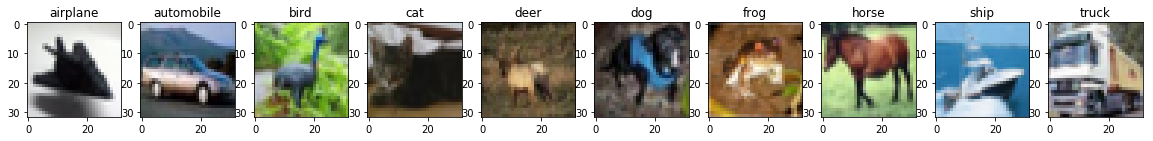

In [51]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [52]:
model = keras.models.load_model('./cifar10.h5')

5 0.97384477
[5]


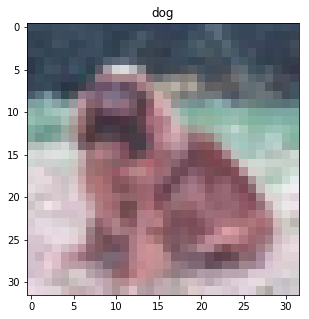

In [93]:
idx = 101
result_idx = model.predict_on_batch(x_test[idx][np.newaxis,...]/255).argmax()
print(result_idx, model.predict_on_batch(x_test[idx][np.newaxis,...]/255)[0,result_idx])
print(y_test[idx])

plt.figure(figsize=(5,5))
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx][0]])
plt.show()

# Saliency map
$$
Saliency(x) := \bigtriangledown_xf(x) = \frac{\partial f(x)}{\partial x}
$$

In [94]:
def get_saliency(idx, model):
    y_c = model.output[0, y_test[idx][0]]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    return saliency([x_test[idx][np.newaxis,...]/255])

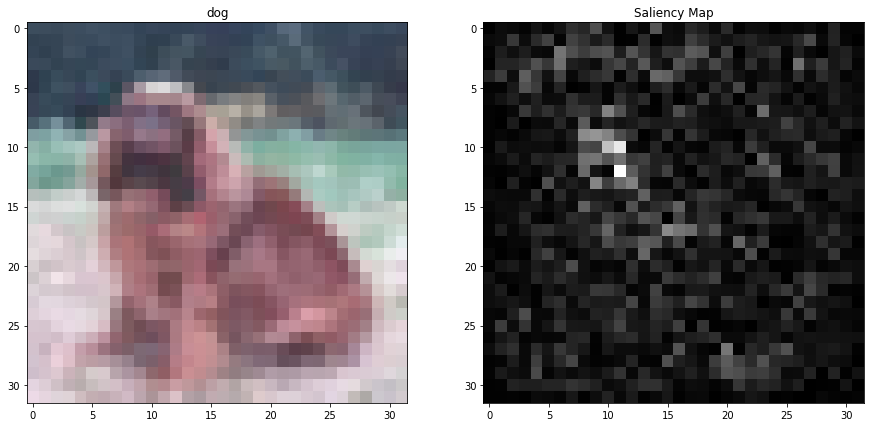

In [95]:
grads_orig = get_saliency(idx, model)
s_map = np.abs(grads_orig[0][0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(122)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.show()

# SmoothGrad
$$
\hat{M}_c(x) = \frac{1}{n}\sum^n_{k=1}M_c(x+\epsilon_k),\ \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

In [96]:
def get_smoothgrad(idx, model, n=10, sigma=1):
    y_c = model.output[0, y_test[idx][0]]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_test[idx][np.newaxis,...]/255
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    return result / n

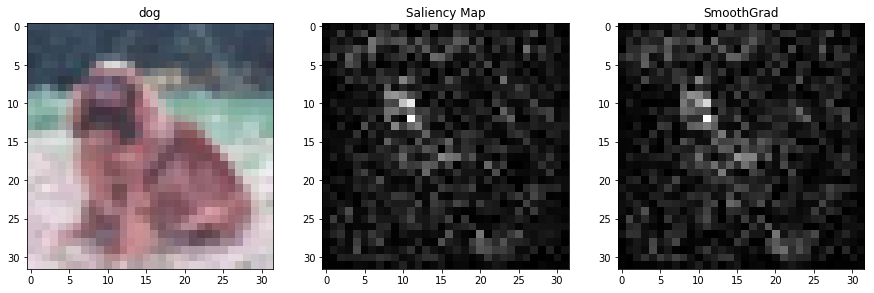

In [97]:
n = 10
sigma = .01

grads_output = get_smoothgrad(idx, model, n, sigma)
sgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(132)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(133)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.show()

# VarGrad
\begin{align}
    \tilde{M}_c(x) &= Var(M_c(x+\epsilon_k)) \\
    &= \frac{1}{n}\sum^n_{k=1}{M_c(x+\epsilon_k)}^2 - {\hat{M}_c(x)}^2
\end{align}

In [98]:
def get_vargrad(idx, model, n=10, sigma=1):
    y_c = model.output[0, y_test[idx][0]]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_test[idx][np.newaxis,...]/255
    
    smoothgrad = np.zeros_like(img_input)
    result = np.zeros_like(img_input)
    for i in range(n):
        smoothgrad += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    smoothgrad /= n
    
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]**2 - smoothgrad**2
    
    return result / n

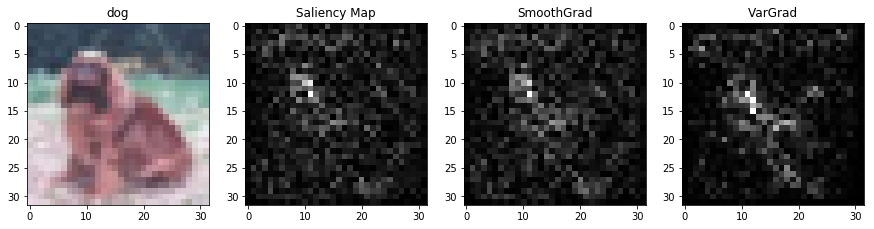

In [99]:
n = 10
sigma = .01

grads_output = get_vargrad(idx, model, n, sigma)

vgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

# Integrated Gradients
\begin{align}
IntegratedGrads^{approx}_i(x) ::= (x_i-x'_i)\ \times\ \sum^m_{k=1}\frac{\partial F(x'+\frac{k}{m}\times(x-x'))}{\partial x_i}\ \times\ \frac{1}{m}
\end{align}

In [100]:
def get_integratedgrad(idx, model, step=50, baseline=None):
    y_c = model.output[0, y_test[idx][0]]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_test[idx][np.newaxis,...]/255
    
    if baseline is None:
        baseline = 0 * img_input

    assert baseline.shape == img_input.shape

    inputs = [baseline+(float(j)/step)*(img_input-baseline) for j in range(step+1)]
    temp = np.zeros_like(img_input)
    for inp in inputs:
        temp += saliency([inp])[0]
    return (img_input-baseline) * temp / step

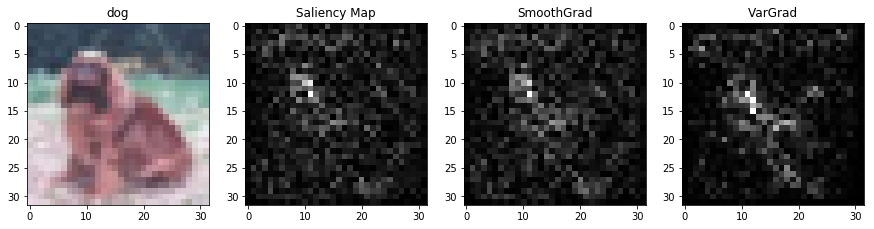

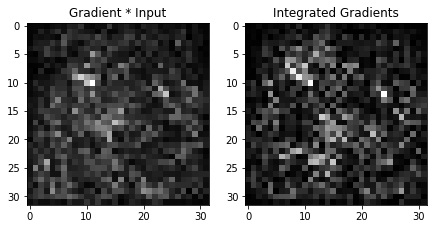

In [118]:
grads_output = get_integratedgrad(idx, model)
integratedgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx,0]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(141)
plot5 = np.abs((x_test[idx]/255)*(grads_orig[0][0])).mean(axis=-1)
plt.imshow(plot5, 'gray')
plt.title('Gradient * Input')
plt.subplot(142)
plt.imshow(integratedgrad, 'gray')
plt.title('Integrated Gradients')
plt.show()